In [1]:
import tensorflow as tf
#tf.config.experimental.list_physical_devices('GPU')
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17390214226637089032
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1362537208835643770
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2951158160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7060668434613401994
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1054908021232179760
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
physical_devices = tf.config.experimental.list_physical_devices()
print("All Physical Devices:", physical_devices)

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('XLA_GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


In [4]:
xla_devices = [device for device in physical_devices if "XLA_GPU:0" in device.name]

if xla_devices:
    try:
        tf.config.set_visible_devices(xla_devices[0], 'XLA_GPU')
        print("Set visible device to:", xla_devices[0])
    except RuntimeError as e:
        print(e)

Set visible device to: PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')


In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
!python --version

Python 3.8.17


In [7]:
import os
import sys
import json
import numpy as np
import time
import mrcnn
from PIL import Image, ImageDraw

In [8]:
!git clone https://github.com/akTwelve/Mask_RCNN.git aktwelve_Mask_RCNN

fatal: destination path 'aktwelve_Mask_RCNN' already exists and is not an empty directory.


In [9]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = 'C:/Users/elixe/tomatodetect/aktwelve_Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [10]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "C:/Users/elixe/tomatodetect/mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [11]:
class TomatoConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "tomato"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 5

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 768

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 324        #324
    LEARNING_RATE = 0.01         #default 0.001
    GRADIENT_CLIP_NORM = 5.0     #default 5.0
    LEARNING_MOMENTUM = 0.9      #default 0.9
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'
    
config = TomatoConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [12]:
from roboflow import Roboflow
rf = Roboflow(api_key="P9uN1AXzej3ELjBu6oN9")
project = rf.workspace("thesis-tomato").project("tomato-ripeness-lbv61")
dataset = project.version(26).download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...
Exporting format coco-segmentation in progress : 85.0%
Version export complete for coco-segmentation format


Extracting Dataset Version Zip to Tomato-Ripeness-26 in coco-segmentation:: 100%|██████████| 471/471 [00:00<00:00, 1566.60it/s]


In [13]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id == 0:
                print('Warning: Class id for "{}" is 0. (0 is reserved for the background)'.format(class_name))
            else:
                self.add_class(source_name, class_id, class_name)

        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [14]:
#modify train and val directories as needed

dataset_train = CocoLikeDataset()
dataset_train.load_data('C:/Users/elixe/tomatodetect/Tomato-Ripeness-26/train/_annotations.coco.json',
                        'C:/Users/elixe/tomatodetect/Tomato-Ripeness-26/train/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('C:/Users/elixe/tomatodetect/Tomato-Ripeness-26/valid/_annotations.coco.json',
                      'C:/Users/elixe/tomatodetect/Tomato-Ripeness-26/valid/')
dataset_val.prepare()

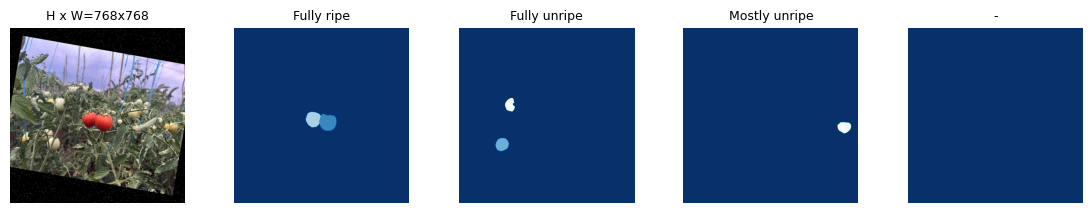

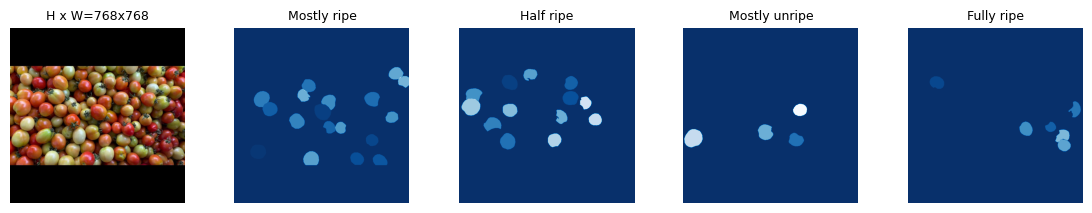

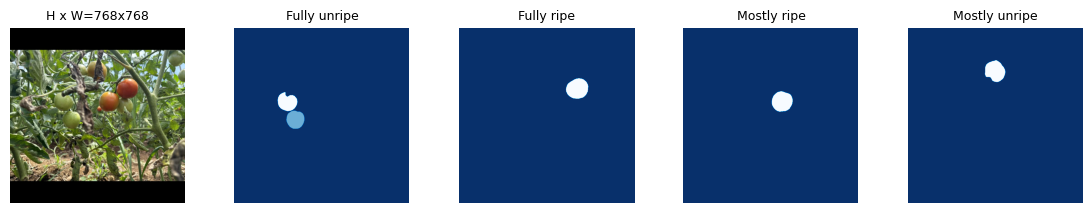

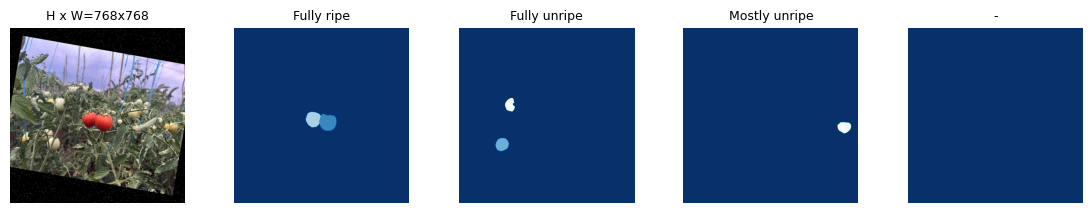

In [15]:
#Showing some train images

dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [16]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [17]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=25, 
            layers='heads')
end_train = time.time()

minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.01

Checkpoint Path: C:/Users/elixe/tomatodetect/aktwelve_Mask_RCNN\logs\tomato20231004T1951\mask_rcnn_tomato_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistribute

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.


324/324 [==============================] - ETA: 0s - batch: 161.5000 - size: 1.0000 - loss: 3.3703 - rpn_class_loss: 0.5004 - rpn_bbox_loss: 1.0424 - mrcnn_class_loss: 0.8200 - mrcnn_bbox_loss: 0.6639 - mrcnn_mask_loss: 0.3435WARNING:tensorflow:From C:\Users\elixe\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
324/324 [==============================] - 635s 2s/step - batch: 161.5000 - size: 1.0000 - loss: 3.3703 - rpn_class_loss: 0.5004 - rpn_bbox_loss: 1.0424 - mrcnn_class_loss: 0.8200 - mrcnn_bbox_loss: 0.6639 - mrcnn_mask_loss: 0.3435 - val_loss: 2.7743 - val_rpn_class_loss: 0.3481 - val_rpn_bbox_loss: 0.9520 - val_mrcnn_class_loss: 0.5199 - val_mrcnn_bbox_loss: 0.6336 - val_mrcnn_mask_loss: 0.3207

In [ ]:
# TRY NOT TO RUN

# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.

start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=50, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

In [ ]:
class InferenceConfig(TomatoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [ ]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [ ]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
import skimage
from datetime import datetime
import cv2

class_names = ['tomato-ripeness','Fully ripe', 
               'Fully unripe', 
               'Half ripe', 
               'Mostly ripe', 
               'Mostly unripe']

In [ ]:
import skimage
real_test_dir = 'C:/Users/elixe/tomatodetect/Tomato-Ripeness-26/test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

In [ ]:
def extract_and_crop(image, mask, roi):
    # Extract the bounding box coordinates
    y1, x1, y2, x2 = roi

    # Crop the original image to the bounding box size
    cropped_image = image[y1:y2, x1:x2]
    
    # Use the mask to set background to black in the cropped image
    extracted = np.where(mask[y1:y2, x1:x2, None], cropped_image, 0)

    # Crop the mask
    cropped_mask = mask[y1:y2, x1:x2]

    return extracted, cropped_mask

def mask_to_polygon(mask):
    """Convert binary mask to COCO polygon representation"""
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    segmentation = []
    for contour in contours:
        # Flatten list and append to segmentation
        segmentation.append(contour.flatten().tolist())
    return segmentation

In [ ]:
def process_dataset(input_folder, output_folder):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialize coco_data
    # This will structure data according to the COCO format
    coco_data = {
        "info": {
            "year": "2023",
            "version": "1",
            "description": "Images taken from Mask RCNN model",
            "contributor": "",
            "url": "",
            "date_created": datetime.now().strftime('%Y-%m-%dT%H:%M:%S+00:00')
        },
        "licenses": [
            {
                "id": 1,
                "url": "",
                "name": "Unknown"
            }
        ],
        "categories": [
            {
                "id": 0,
                "name": "tomato-ripeness",
                "supercategory": "none"
            },
            {
                "id": 1,
                "name": "Fully ripe",
                "supercategory": "tomato-ripeness"
            },
            {
                "id": 2,
                "name": "Fully unripe",
                "supercategory": "tomato-ripeness"
            },
            {
                "id": 3,
                "name": "Half ripe",
                "supercategory": "tomato-ripeness"
            },
            {
                "id": 4,
                "name": "Mostly ripe",
                "supercategory": "tomato-ripeness"
            },
            {
                "id": 5,
                "name": "Mostly unripe",
                "supercategory": "tomato-ripeness"
            },
        ],
        "images": [],
        "annotations": []
    }
    # Initialize annotation_id, and image_id_counter
    annotation_id = 0
    image_id_counter = 0
    
    # List all images in the input folder
    image_paths = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Limit to only one image for testing
    #image_paths = [image_paths[2]]
    
    # Process each image
    for image_path in image_paths:
        # Load image
        img = skimage.io.imread(image_path)
        img_arr = np.array(img)
        results = model.detect([img_arr], verbose=1)
        r = results[0]
        visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                    dataset_val.class_names, r['scores'], figsize=(5,5))

        # Extract, crop, and save masks
        for i in range(r['masks'].shape[2]):
            mask = r['masks'][:,:,i].astype(np.uint8)
            roi = r['rois'][i]
            class_id = int(r['class_ids'][i])

            cropped_masked_image, cropped_mask = extract_and_crop(img, mask, roi)  # Adjust this function to return both image and mask
            base_filename = os.path.basename(image_path).split('.')[0]
            output_filename = f"{base_filename}_masked_cropped_{i}_{class_names[class_id]}.png"
            skimage.io.imsave(os.path.join(output_folder, output_filename), cropped_masked_image)

            cropped_mask_single_channel = cropped_mask

            # Now find contours on this single-channel cropped mask to get the segmentation
            segmentation_cropped = mask_to_polygon(cropped_mask_single_channel)

            # Convert roi to bbox format for cropped image: [x, y, width, height]
            x, y, width, height = 0, 0, cropped_masked_image.shape[1], cropped_masked_image.shape[0] 
            bbox_cropped = [x, y, width, height]

            # Calculate area from the cropped mask
            area_cropped = bbox_cropped[2] * bbox_cropped[3]

            # Ensure the values are native Python types (not numpy types) for JSON serialization
            bbox_cropped = [int(value) for value in bbox_cropped]
            area_cropped = int(area_cropped)
            segmentation_cropped = [[int(coord) for coord in sublist] for sublist in segmentation_cropped]

            # Add image entry
            coco_data["images"].append({
                "id": image_id_counter,
                "license": 1,
                "file_name": output_filename,
                "height": cropped_masked_image.shape[0],
                "width": cropped_masked_image.shape[1],
                "date_captured": datetime.now().strftime('%Y-%m-%dT%H:%M:%S+00:00')
            })

            # Add annotation entry
            coco_data["annotations"].append({
                "id": annotation_id,
                "image_id": image_id_counter, # use the latest image ID
                "category_id": class_id,
                "bbox": bbox_cropped,
                "area": area_cropped,
                "segmentation": segmentation_cropped,
                "iscrowd": 0
            })

            # Increment counters
            image_id_counter += 1
            annotation_id += 1

    # Save all annotations to a single JSON file in COCO format
    with open(os.path.join(output_folder, "coco_annotations.json"), "w") as json_file:
        json.dump(coco_data, json_file, indent=4)

In [ ]:
# Train set
input_folder1 = "C:/Users/elixe/tomatodetect/Tomato-Ripeness-26/train"
output_folder1 = "C:/Users/elixe/tomatodetect/segmentedtomato-train26"
process_dataset(input_folder1, output_folder1)

In [ ]:
# Validation set
input_folder2 = "C:/Users/elixe/tomatodetect/Tomato-Ripeness-26/valid"
output_folder2 = "C:/Users/elixe/tomatodetect/segmentedtomato-valid26"
process_dataset(input_folder2, output_folder2)

In [ ]:
# Test set
input_folder1 = "C:/Users/elixe/tomatodetect/Tomato-Ripeness-26/test"
output_folder1 = "C:/Users/elixe/tomatodetect/segmentedtomato-test26"
process_dataset(input_folder1, output_folder1)